# DIY Document Scanner using Python and OpenCV

This can be achieved in three easy steps:
1. Edge Detection
2. Contour Detection
3. Four point transformation

Edge Detection is commonly used to identify and understand objects in an image. It is useful in cases when all the intricate details of an image are not needed, but rather only when you need the overall shape. Edge detection provides information where image intensity changes drastically. It may or may not form a closed shape.

Contours are defined as refined boundaries of objects and can be really helpful in detecting objects.

Four point transformation is used to obtain a top-down, “birds eye view” of an image. It is a bijection (one-to-one correspondence) that maps lines to lines, and thus a collineation.

In [1]:
import cv2
import numpy as np
import imutils
from skimage.filters import threshold_local
import matplotlib.pyplot as plt
#from dataPath import DATA_PATH
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [3]:
#Perspective Transformation function
def four_point_transform(image, points):
	#Extract a consistent order of the points and unpack them individually into the rect
    #Do so by initializing a list of coordinates that will be ordered
    #The first to last entry are mapped onto the top left, top right, bottom right, and bottom left respectively
    #The second entry will have the smallest sum
    #The fourth entry will have the largest
	rect = np.zeros((4, 2), dtype = "float32")
	sums = points.sum(axis = 1)
	rect[0] = points[np.argmin(sums)]
	rect[2] = points[np.argmax(sums)]
	#Next, let's compute the differences between the points
    #Second entry will have the smallest difference, while the bottom left will be the largest
	diff = np.diff(points, axis = 1)
	rect[1] = points[np.argmin(diff)]
	rect[3] = points[np.argmax(diff)]
	(top_left, top_right, bottom_right, bottom_left) = rect
	#recalculte the width of the transformed image
    #this will be based on the maximum distance between the bottom right and left x-coordinates (or the top)
	widthA = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
	widthB = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	#recalculte the height of the transformed image
    #this will be based on the maximum distance between the bottom right and left y-coordinates (or the top)
	heightA = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
	heightB = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
    #now we have the 'birds eye view' of the new image'
    #we must define the new points of the transformed image
	distance = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	#extract the perspective transform matrix
	PTM = cv2.getPerspectiveTransform(rect, distance)
    #apply the transformation to get the warped image
	warped = cv2.warpPerspective(image, PTM, (maxWidth, maxHeight))
	return warped


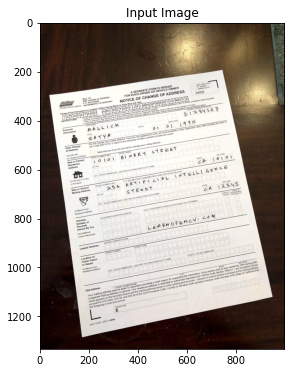

In [4]:
# Read image
img = cv2.imread("scanned-form.jpg")
plt.imshow(img[:,:,::-1])
plt.title("Input Image")
plt.show()

Step 1: Edge Detection

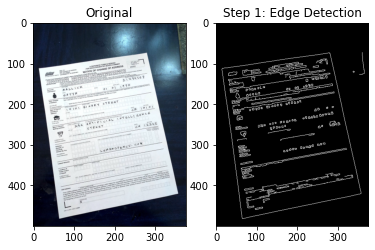

In [5]:
# load the image
image = cv2.imread("scanned-form.jpg")
# determine the ratio of the height and width of the image
ratio = image.shape[0] / 500.0
# copy the image and resize it
original = image.copy()
image = imutils.resize(image, height = 500)
# convert the image to grayscale, blur it, and find edges using the canny function
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

# show the original image and the edge detected image
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(image)
plt.title("Original")
f.add_subplot(1,2, 2)
plt.imshow(edged)
plt.title("Step 1: Edge Detection")
plt.show()

Step 2: Find Contours

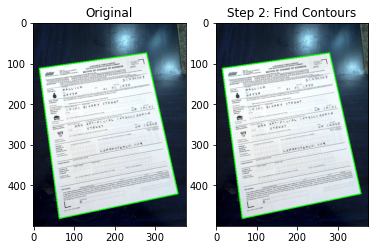

In [6]:
# 1. identify the contours of the edged image
# 2. identify and select the largest contonurs and discard the rest
# 3. initalize/configure the screen contonours
contours= cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours= imutils.grab_contours(contours)
contours= sorted(contours, key = cv2.contourArea, reverse = True)[:5]

# to do steps 2 and 3, loop over the contours
for c in contours:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    #if we can identify four contours, then we have identified a screen
	if len(approx) == 4:
		screenCnt = approx
		break
        
# show the contour (AKA the outline) in the original image
screenContours=cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(image)
plt.title("Original")
f.add_subplot(1,2, 2)
plt.imshow(screenContours)
plt.title("Step 2: Find Contours")
plt.show()

Step 3: Four Point Transformation

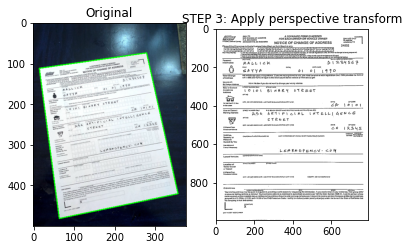

In [8]:
# use four point transform to transform the original image (so that it can be viewed from a birds eye view)
warped = four_point_transform(original, screenCnt.reshape(4, 2) * ratio)
#to get that 'black and white'printed effect
#convert the warped image into gray scale and use the threshold to get a greater contrast
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255
# show the original and scanned images

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(image)
plt.title("Original")
f.add_subplot(1,2, 2)
plt.imshow(warped)
plt.title("STEP 3: Apply perspective transform")
plt.show()